# DeepRouteSet
DeepRouteSet uses LSTM to generate new moonboard problem. 
It is modified from the homework "Improvise a Jazz Solo with an LSTM Network" of Coursera course "Sequence Model".
Yi-Shiou Duh(Allenduh@stanford.edu)

In [32]:
from os import environ
environ['TF_CPP_MIN_LOG_LEVEL'] = '1'
environ["XLA_FLAGS"] = "--xla_gpu_cuda_data_dir=/home/valsp/miniconda3/envs/tf/lib"


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle
from collections import Counter
from pathlib import Path
import tensorflow as tf
from tensorflow.keras.backend import argmax
from tensorflow.keras.models import load_model, Model
from tensorflow.keras.layers import Dense, Activation, Input, LSTM, Reshape, Lambda, RepeatVector
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import Adam
from datetime import datetime
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

from DeepRouteSet_helper import *


In [34]:
cwd = Path().cwd()

In [35]:
# TODO: all data preparation should be moved out of here to preprocessing

In [36]:
# list physical devices
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  1


## 1 - Data preparation

We want more moonboard problems, and high-quality, hard moonboard problem is especially not enough. Thanksfully, with LSTM, we can generate unlimited problems. By carefully choosing the source of author and 3 stars high quality problems, we can generate new moonboard problem of better quality.


### 1.1 - Dataset

We will train our RNN using a sequence of moves. We already preprocessed moonboard problems from a set of holds (e.g., [8A, 11B, 13C, ...]) to the list of holds with designated hand operation (e.g., [8A-LH, 11B-RH...]). Each point will be assigned to a moonboard "value". After training, RNN will then be able to generate new move sequences.

### 1.2 - Define Path to read handString_seq

5 files: Handsequence (benchmark YN/ grade YN) and raw data with URL: 

In [38]:
# TODO: this takes fkn forever and should definitely be migrated to a single load of the whole dataset
with open(cwd.parent / 'preprocessing" / "benchmark_handString_seq_X', 'rb') as f:
    benchmark_handString_seq = pickle.load(f)
with open(cwd.parent / 'preprocessing" / "benchmarkNoGrade_handString_seq_X', 'rb') as f:
    benchmarkNoGrade_handString_seq = pickle.load(f)
with open(cwd.parent / 'preprocessing" / "nonbenchmark_handString_seq_X', 'rb') as f:
    nonbenchmark_handString_seq = pickle.load(f)
with open(cwd.parent / 'preprocessing" / "nonbenchmarkNoGrade_handString_seq_X', 'rb') as f:
    nonbenchmarkNoGrade_handString_seq = pickle.load(f)   
with open(cwd.parent / 'raw_data" / "moonGen_scrape_2016_cp', 'rb') as f:
    MoonBoard_2016_withurl = pickle.load(f)    

In [39]:
# Example of input sequence
benchmark_handString_seq["189344"]

['B4-LH', 'D6-RH', 'F9-LH', 'G11-RH', 'C15-LH', 'H18-RH']

In [40]:
# raw data URL file looks like
MoonBoard_2016_withurl["189344"]

{'problem_name': 'JUST TRAINING',
 'info': ['Alex Biale',
  '195 climbers have repeated this problem',
  '7C+ (User grade 8A)',
  'Feet follow hands',
  ''],
 'url': 'https://moonboard.com/Problems/View/189344/just-training',
 'num_empty': 0,
 'num_stars': 3,
 'moves': [{'Id': 1879483,
   'Description': 'B4',
   'IsStart': True,
   'IsEnd': False},
  {'Id': 1879484, 'Description': 'C15', 'IsStart': False, 'IsEnd': False},
  {'Id': 1879485, 'Description': 'D6', 'IsStart': True, 'IsEnd': False},
  {'Id': 1879486, 'Description': 'F9', 'IsStart': False, 'IsEnd': False},
  {'Id': 1879487, 'Description': 'G11', 'IsStart': False, 'IsEnd': False},
  {'Id': 1879488, 'Description': 'H18', 'IsStart': False, 'IsEnd': True}],
 'grade': '7C+',
 'UserGrade': '8A',
 'isBenchmark': True,
 'repeats': 195,
 'ProblemType': 'Crimp',
 'IsMaster': False,
 'setter': {'Id': '7A90397F-74F9-4858-846B-D3CA9E4F70FF',
  'Nickname': 'Alex Biale',
  'Firstname': 'Alex',
  'Lastname': 'Biale',
  'City': 'Boulder',
  '

### 1.3 - Pick good moonboard problem 

Only pick the problem by choosing good setter and pick 3 starts problems. Store in the goodKeyList
  

* Collect Name of all setters

In [41]:
# All setter with non error name
setterList = []
countNumOfErrorUsername = 0
for key in MoonBoard_2016_withurl.keys():
    try:
        setterList.append(MoonBoard_2016_withurl[key]["setter"]["Nickname"])
    except:
        countNumOfErrorUsername += 1

* Count how many problems each setter has set and add to dict

In [42]:
# TODO: reverse true? this means we are iterating in increasing number of problems - would be faster to do it in decreasing order
setterDict = {
    k: v
    for k, v in sorted(
        Counter(setterList).items(), key=lambda item: item[1], reverse=True
    )
}

* Add experienced setter and Benchmark setter

In [43]:
# add setter with 50+ experience or Benchmark setter
goodSetterName = []
for key in setterDict.keys():
    if setterDict[key] > 50:
        goodSetterName.append(key)
for key in MoonBoard_2016_withurl.keys():
    try:
        if MoonBoard_2016_withurl[key]["isBenchmark"] == True:
            goodSetterName.append(MoonBoard_2016_withurl[key]["setter"]["Nickname"])
    except:
        pass
print("Total good setter: ", len(goodSetterName))

Total good setter:  425


* Define a goodProblemKeyList

In [44]:
# Pick Extended BenchMark, high repeat number, author make many problem, high rate
count = 0
goodProblemKeyList = []
for key in MoonBoard_2016_withurl.keys():
    try:
        if MoonBoard_2016_withurl[key]["isBenchmark"] == True:
            goodSetterName.append(MoonBoard_2016_withurl[key]["setter"]["Nickname"])
    except:
        pass


for key in MoonBoard_2016_withurl.keys():
    try:
        # TODO: this adds multiple of good problems, fix and add weighting
        if MoonBoard_2016_withurl[key]["setter"]["Nickname"] in goodSetterName:
            goodProblemKeyList.append(key)
            count = count + 1
        if MoonBoard_2016_withurl[key]["isBenchmark"] == True:
            goodProblemKeyList.append(key)
            count = count + 1
        if MoonBoard_2016_withurl[key]["repeats"] > 50:
            goodProblemKeyList.append(key)
            count = count + 1
        if MoonBoard_2016_withurl[key]["num_stars"] == 3:
            goodProblemKeyList.append(key)
            count = count + 1
    except:
        pass
print("Total amount of good problems: ", count)

Total amount of good problems:  19842


### 1.4 - Grade filter

We will seperate problems into 3 difficulty range: Hard (V8 and up) medium (V6 to V8) and easy (V4 V5). So that our training set has the similar difficulty. This will help the problems generated to be more consistant in the difficulty.

In [45]:
# TODO: model is split into 3 different versions for different grade ranges, reduces training data size
# TODO: it could be better to add the grade as a feature, which would allow the model to learn connection between grade and output

In [46]:
easyProblemKeyList = []
mediumProblemKeyList = []
hardProblemKeyList = []
for key in goodProblemKeyList:
    # TODO: this results in only graded problems being used in training
    if MoonBoard_2016_withurl[key]['grade'] in ("6B+", "6C", "6C+"): # V4 V5
        easyProblemKeyList.append(key)
    if MoonBoard_2016_withurl[key]['grade'] in ("7A", "7A+", "7B", "7B+"): # V6 7 8
        mediumProblemKeyList.append(key)
    if MoonBoard_2016_withurl[key]['grade'] in ("7B", "7B+", "7C", "7C+", "8A", "8A+", "8B"): # V8 9 10 11 12 13
        hardProblemKeyList.append(key)        
print("num of easy problems:", len(easyProblemKeyList)) 
print("num of medium problems:", len(mediumProblemKeyList))
print("num of hard problems:", len(hardProblemKeyList))

num of easy problems: 9839
num of medium problems: 8267
num of hard problems: 4639


### 1.5 - Collect good and proper grade range into handString training set
Collect into handStringList as input of RNN

* Define handStringList and add benchmark

In [47]:
# ensemble to a StringList
print("Number of benchmark training example: ", len(benchmark_handString_seq))

Number of benchmark training example:  358


* Now add more problems and add more Benchmark problem to emphasize Benchmark

* Select a proper grade level 

In [48]:
handStringList = collectHandStringIntoList(mediumProblemKeyList)

In [49]:
# Total training sample
numOfTrainingSample = len(handStringList)
print("Number of total training example (filter): ", numOfTrainingSample)

Number of total training example (filter):  6681


### 1.6 - construct total reservoir of all avalible holds
Create two dictionaries: 
* holdStr_to_holdIx: "J5-LH" has index =  127
* holdIx_to_holdStr: index 277 is hold B15-RH

* You can reload the dictionaries here (Skipe the later cells) 

In [50]:
with open(cwd.parent / "raw_data" / "holdStr_to_holdIx", 'rb') as f:
    holdStr_to_holdIx = pickle.load(f)
with open(cwd.parent / "raw_data" / "holdIx_to_holdStr", 'rb') as f:
    holdIx_to_holdStr = pickle.load(f)  
numOfPossibleHolds = 277

* Code to regenerate maps

In [51]:
# TODO: rewrite, very slow
# # Merge all string to big list to know how many string to consider
# holdsReservoir = [] 
# for i in range(len(handStringList)):
#     holdsReservoir = holdsReservoir + handStringList[i]
# #holdsReservoir = sorted(holdsReservoir)  It will be great to sort the num of String from bottom to top.  
# holdsReservoir = list(set(holdsReservoir)) # Delete repetitive string
# print('Total holds avalible (include L / R): ', len(holdsReservoir))
# numOfPossibleHolds = len(holdsReservoir)

# # Build a dictionary convert String "J5-LH" to index
# holdStr_to_holdIx = {}
# holdStr_to_holdIx["End"] = 0  # End hold
# for i in range(len(holdsReservoir)):
#     holdStr_to_holdIx[holdsReservoir[i]] = i + 1
# print('For example, "J5-LH" has index = ', holdStr_to_holdIx["J5-LH"])   

# holdIx_to_holdStr = {v: k for k, v in holdStr_to_holdIx.items()}
# print('Reverse dictionary: index 23 is hold', holdIx_to_holdStr[23])  

# save_pickle(holdStr_to_holdIx, cwd / 'holdStr_to_holdIx')
# save_pickle(holdIx_to_holdStr, cwd / 'holdIx_to_holdStr')

### 1.7 - Prepare RNN's inputXY 
Use loadSeqXYFromString to shift Y from X by 1

In [52]:
X, Y, n_values = loadSeqXYFromString(
    handStringList,
    holdStr_to_holdIx,
    m=numOfTrainingSample,
    maxNumOfHands=12,
    numOfPossibleHolds=numOfPossibleHolds,
)
print("number of training examples:", X.shape[0])
print("Tx (length of sequence):", X.shape[1])
print("total # of unique values:", n_values)
print("shape of X:", X.shape)
print("Shape of Y:", Y.shape)

number of training examples: 6681
Tx (length of sequence): 12
total # of unique values: 278
shape of X: (6681, 12, 278)
Shape of Y: (12, 6681, 278)


- `X`: This is an `(m, Tx, n_values)` dimensional array. 
    - We have m training examples, each of which has `T_x=12` holds (if < 12 remainder are `"End"`/`0`). 
    - At each move step, the input is one of n_values different possible values, represented as a one-hot vector. 
        - For example, `X[i,t,:]` is a one-hot vector representing the hold at sequence position `t`. 

- `Y`: a `(Ty, m, n_values)` dimensional array
    - This is essentially the same as `X`, but shifted one step to the left (to the previous move). 
    - Notice that the data in `Y` is **permuted** to be dimension `(Ty, m, n_values)`, where `Ty = Tx`. This format makes it more convenient to feed into the LSTM later.
    - Similar to the music generator, we're using the previous values to predict the next value.
        - So our sequence model will try to predict $y^{\langle t \rangle}$ given $x^{\langle 1\rangle}, \ldots, x^{\langle t \rangle}$. 

- `n_values`: The number of unique values in this dataset. This should be `n_values`. 


### 1.8 - Overview of our model

* $X = (x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, \cdots, x^{\langle T_x \rangle})$ is a window of size $T_x$ scanned over the climbing moves. 
* Each $x^{\langle t \rangle}$ is an index corresponding to a value.
* $\hat{y}^{t}$ is the prediction for the next value.
* We will be training the model on random 12 values padded  with `"End"` if the climbing problem end before. 
    - We are setting each of the snippets to have the same length $T_x = 12$ to make vectorization easier.

## Overview of parts 2 and 3 (If you already trained the model, skip to Prediction part 4)


- We're going to train a model that predicts the next hold in a style that is similar to the climbing problems that it's trained on.  The training is contained in the weights and biases of the model. 
- In Part 3, we're then going to use those weights and biases in a new model which predicts a series of holds, using the previous hold to predict the next hold. 
- The weights and biases are transferred to the new model using 'global shared layers' described below"


## 2 - Building the model (If you already trained the model, skip to Prediction part)

* Build and train a model that will learn climbing moves patterns. 
* The model takes input X of shape $(m, T_x, n_values)$ and labels Y of shape $(T_y, m, n_values)$. 
* We will use an LSTM with hidden states that have $n_{a} = 64$ dimensions.

In [53]:
# number of dimensions for the hidden state of each LSTM cell.
n_a = 64 


#### Sequence generation uses a for-loop
* If you're building an RNN where, at test time, the entire input sequence $x^{\langle 1 \rangle}, x^{\langle 2 \rangle}, \ldots, x^{\langle T_x \rangle}$ is given in advance, then Keras has simple built-in functions to build the model. 
* However, for **sequence generation, at test time we don't know all the values of $x^{\langle t\rangle}$ in advance**.
* Instead we generate them one at a time using $x^{\langle t\rangle} = y^{\langle t-1 \rangle}$. 
    * The input at time `t` is the prediction at the previous time step `t-1`.

#### Shareable weights
* The function `routeSetmodel()` will call the LSTM layer $T_x$ times using a for-loop.
* It is important that all $T_x$ copies have the same weights. 
    - The $T_x$ steps should have shared weights that aren't re-initialized.
* Referencing a globally defined shared layer will utilize the same layer-object instance at each time step.
* Benefits of using shareable weights:
    - reduced computation and space requirements
    - theoretically has the ability to memorize long-term dependencies
    - we may however learn more complex patterns if we don't share weights which is unlikely to require much more computation as we only generate 12 holds 


The key steps for implementing layers with shareable weights in Keras are: 
1. Define the layer objects (we will use global variables for this).
2. Call these objects when propagating the input.

#### 3 types of global variables layers:
- [Reshape()](https://keras.io/layers/core/#reshape): Reshapes an output to a certain shape.
- [LSTM()](https://keras.io/layers/recurrent/#lstm): Long Short-Term Memory layer
- [Dense()](https://keras.io/layers/core/#dense): A regular fully-connected neural network layer.


In [86]:
# TODO: testing and reconsideration of shared weights
# currently checking whether they are needed to transfer weights to the inference model
# see above benefits of using shared weigths
# need to test not using shared weights between layers (would still somehow need to pass onto inference model)
LSTM_cell = LSTM(n_a, return_state=True)
densor = Dense(n_values, activation="softmax")

#### Inputs 
* The `Input()` layer is used for defining the input `X` as well as the initial hidden state 'a0' and cell state `c0`.
* The `shape` parameter takes a tuple that does not include the batch dimension (`m`).
```Python
X = Input(shape=(Tx, n_values)) # X has 3 dimensions and not 2: (m, Tx, n_values)
```


#### Step 1: Outputs 
- Create an empty list `outputs` to save the outputs of the LSTM Cell at every time step.

#### Step 2: Loop through time steps
* Loop for $t \in 1, \ldots, T_x$:

#### 2A. Select the `t` time-step vector from `X`.
* `X` has the shape `(m, Tx, n_values)`.
* The shape of the `t` selection should be `(n_values,)`.

#### 2B. Reshape `x` to be `(1,n_values)`.
* Use the `reshapor()` layer.  It is a function that takes the previous layer as its input argument.

#### 2C. Run `x` through one step of LSTM_cell.
* Initialize the `LSTM_cell` with the previous step's hidden state `a` and cell state `c`. 
* Use the following formatting:
```python
next_hidden_state, _, next_cell_state = LSTM_cell(inputs=input_x, initial_state=[previous_hidden_state, previous_cell_state])
```

#### 2D. Dense layer
* Propagate the LSTM's hidden state through a dense+softmax layer using `densor`. 
    
#### 2E. Append output
* Append the output to the list of `outputs`.


#### Step 3: After the loop, create the model
* Use the Keras `Model` object to create a model.
* specify the inputs and outputs:
```Python
model = Model(inputs=[input_x, initial_hidden_state, initial_cell_state], outputs=the_outputs)
```
* Choose the appropriate variables for the input tensor, hidden state, cell state, and output.

In [96]:
def deepRouteSet(LSTM_cell, densor, Tx, n_a, n_values):
    """
    Training model for route generation we reuse these  weights with a different network in order to generate routes
    
    Arguments:
    Tx -- length of the climbing route (padded by "End" up to this length)
    n_a -- the number of activations used by the LSTM cells in our model
    n_values -- number of unique values in the climbing move data 
    
    Returns:
    model -- a keras instance model with n_a activations
    """
    
    # Define the input layer and specify the shape
    X = Input(shape=(Tx, n_values))
    
    # Define the initial hidden state a0 and initial cell state c0
    # using `Input`
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    
    # Step 1: Create empty list to append the outputs while you iterate
    outputs = []
    
    # Step 2: Loop
    for t in range(Tx):      
        # Step 2.A: select the "t"th time step vector from X. 
        x = Lambda(lambda z: z[:, t, :])(X)   
        # Step 2.B: Use reshapor to reshape x to be (1, n_values)
        x = Reshape((1, n_values))(x)  # from (?, n_values) to (?, 1, n_values)
        # Step 2.C: Perform one step of the LSTM_cell
        a, _, c = LSTM_cell(inputs = x, initial_state = [a, c])
        # Step 2.D: Apply densor to the hidden state output of LSTM_Cell
        out = densor(a)
        # Step 2.E: add the output to "outputs"
        outputs.append(out)
        
    # Step 3: Create model instance
    return Model(inputs = [X, a0, c0], outputs = outputs)
    

#### Create the model object
* Run the following cell to define your model. 
* We will use `Tx=12`, `n_a=64` (the dimension of the LSTM activations), and `n_values=n_values`. 
* This cell may take a few seconds to run. 

In [88]:
model = deepRouteSet(LSTM_cell, densor, 12, 64, n_values)
# Check model
# model.summary()

#### Compile the model for training
- optimizer: Adam
- loss: categorical cross-entropy (for multi-class classification)

In [58]:
opt = Adam(learning_rate=0.01, beta_1=0.9, beta_2=0.999)

model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

#### Initialize hidden state and cell state
Finally, let's initialize `a0` and `c0` for the LSTM's initial state to be zero. 

In [59]:
m = numOfTrainingSample
a0 = np.zeros((m, n_a))
c0 = np.zeros((m, n_a))

#### Train the model
* Lets now fit the model! 
* We will turn `Y` into a list, since the cost function expects `Y` to be provided in this format 
    - `list(Y)` is a list with `Tx` items, where each of the list items is of shape (numOfTrainingSample,n_values). 
    - Lets train for 100 epochs. This will take a few minutes. 

In [65]:
# tensorboard callback
log_dir = cwd / "logs" / "DeepRouteSet" / datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = TensorBoard(log_dir=log_dir, histogram_freq=1)

# checkpoint callback
checkpoint_path = (
    cwd / "checkpoints" / "DeepRouteSet" / "epoch{epoch:02d}-loss{val_loss:.2f}.h5"
)
cp_callback = ModelCheckpoint(
    filepath=str(checkpoint_path),
    save_weights_only=True,
    save_best_only=True,
    verbose=1,
)

In [66]:
# load weights instead of retraining
history = model.fit([X, a0, c0], list(Y), batch_size=64, epochs=100, callbacks=[tensorboard_callback, cp_callback], validation_split=0.2)
# model.load_weights('DeepRouteSet_medium.h5')

Epoch 1/100
84/84 [==============================] - ETA: 0s - loss: 30.5010 - dense_3_loss: 3.2584 - dense_3_1_loss: 3.3687 - dense_3_2_loss: 4.3106 - dense_3_3_loss: 4.6057 - dense_3_4_loss: 4.6938 - dense_3_5_loss: 4.4924 - dense_3_6_loss: 3.3903 - dense_3_7_loss: 1.6861 - dense_3_8_loss: 0.5584 - dense_3_9_loss: 0.1207 - dense_3_10_loss: 0.0133 - dense_3_11_loss: 0.0025 - dense_3_accuracy: 0.1241 - dense_3_1_accuracy: 0.1239 - dense_3_2_accuracy: 0.0427 - dense_3_3_accuracy: 0.0378 - dense_3_4_accuracy: 0.0369 - dense_3_5_accuracy: 0.0496 - dense_3_6_accuracy: 0.3194 - dense_3_7_accuracy: 0.7103 - dense_3_8_accuracy: 0.9216 - dense_3_9_accuracy: 0.9850 - dense_3_10_accuracy: 0.9979 - dense_3_11_accuracy: 1.0000
Epoch 1: val_loss improved from inf to 31.46139, saving model to /mnt/c/Users/valsp/source/repos/MoonBoardRNN/model/checkpoints/DeepRouteSet/epoch01-loss31.46.h5
84/84 [==============================] - 10s 120ms/step - loss: 30.5010 - dense_3_loss: 3.2584 - dense_3_1_loss: 

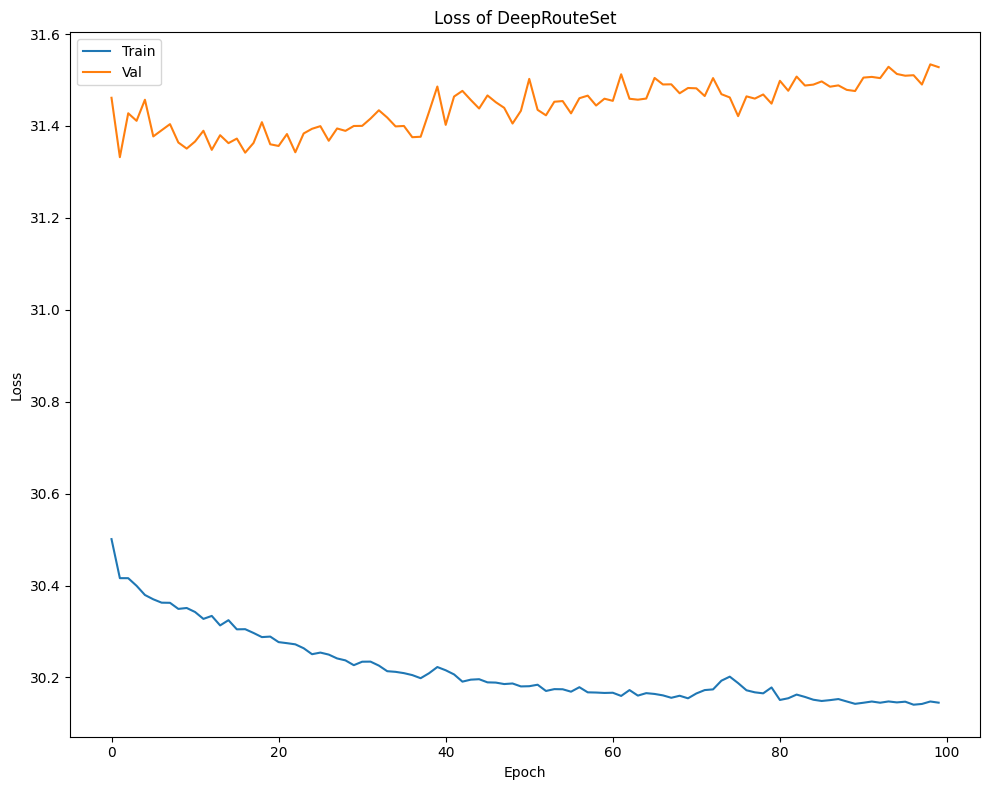

In [78]:
def plot_history(history, model_name, acc=False):
    """
    Plot the training history of the model
    """
    # Plot training & validation accuracy values
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    if acc:
        acc = history.history['sparse_categorical_accuracy']
        val_acc = history.history['val_sparse_categorical_accuracy']

    _, axes = plt.subplots(nrows = 1, ncols = (2 if acc else 1), figsize=(10, 8))
    ax1 = axes[0] if acc else axes
    ax1.plot(loss)
    ax1.plot(val_loss)
    ax1.set_title('Loss of ' + model_name)
    ax1.set_ylabel('Loss')
    ax1.set_xlabel('Epoch')
    ax1.legend(['Train', 'Val'], loc='upper left')

    if acc:
        axes[1].plot(acc)
        axes[1].plot(val_acc)
        axes[1].set_title('Accuracy of '+ model_name)
        axes[1].set_ylabel('Accuracy')
        axes[1].set_xlabel('Epoch')
        axes[1].legend(['Train', 'Val'], loc='upper left')
    plt.tight_layout()

plot_history(history, "DeepRouteSet")


In [67]:
# TODO: loss is improving following a similar curve to normal but accuracy is not right, revaluate


In [ ]:
best_cp = sorted(checkpoint_path.parent.glob("*.h5"), key=lambda p: float(p.stem.split("-")[1][4:]))[0]
model.load_weights(best_cp)

PosixPath('/mnt/c/Users/valsp/source/repos/MoonBoardRNN/model/checkpoints/DeepRouteSet/epoch02-loss31.33.h5')

## 3 - Generating moonboard problem

We already have trained model which has learned the patterns of climbing move and route set spirit. Lets now use this model to synthesize new route.
Importantly we reuse the `LSTM_cell` and `densor` layers from the model we trained.

### 3.1 - The inference model

At each step of sampling:
* Take as input the activation '`a`' and cell state '`c`' from the previous state of the LSTM.
* Forward propagate by one step.
* Get a new output activation as well as cell state. 
* The new activation '`a`' can then be used to generate the output using the fully connected layer, `densor`. 


* Sample x to be the one-hot version of '`out`'. 
* This allows you to pass it to the next LSTM's step.  
* use the add_one function inside of the Lambda function
```py
result = Lambda(add_one)(input_var)
```

In [79]:
def deepRouteSetPred(LSTM_cell, densor, n_values = n_values, n_a = 64, Ty = 12):
    """
    Uses the trained "LSTM_cell" and "densor" from model() to generate a sequence of values.
    
    Arguments:
    LSTM_cell -- the trained "LSTM_cell" from model(), Keras layer object
    densor -- the trained "densor" from model(), Keras layer object
    n_values -- integer, number of unique values
    n_a -- number of units in the LSTM_cell
    Ty -- integer, number of time steps to generate
    
    Returns:
    inference_model -- Keras model instance
    """
    # TODO: replace this lambda function with actual layers
    def one_hot(x):
        x = argmax(x)
        x = tf.one_hot(x, n_values) 
        x = RepeatVector(1)(x)
        return x
    
    # Define the input of your model with a shape 
    x0 = Input(shape=(1, n_values))
    
    # Define s0, initial hidden state for the decoder LSTM
    a0 = Input(shape=(n_a,), name='a0')
    c0 = Input(shape=(n_a,), name='c0')
    a = a0
    c = c0
    x = x0

    # Step 1: Create an empty list of "outputs" to later store your predicted values
    outputs = []
    
    # Step 2: Loop over Ty and generate a value at every time step
    for t in range(Ty):
        
        # Step 2.A: Perform one step of LSTM_cell
        # TODO: this is using the same LSTM_cell for all time steps?
        a, _, c = LSTM_cell(x, initial_state=[a, c])
        
        # Step 2.B: Apply Dense layer to the hidden state output of the LSTM_cell
        out = densor(a)

        # Step 2.C: Append the prediction "out" to "outputs". out.shape = (None, n_values)
        outputs.append(out)
        
        # Step 2.D: 
        # Select the next value according to "out",
        # Set "x" to be the one-hot representation of the selected value
        # See instructions above.
        x = Lambda(one_hot)(out)
        
        
    # Step 3: Create model instance with the correct "inputs" and "outputs"
    return Model(inputs = [x0, a0, c0], outputs = outputs)


In [1]:
print(LSTM_cell.get_config(), LSTM_cell.get_weights())
print(densor.get_config(), densor.get_weights())

In [97]:
# Create inference model with reuses the trained LSTM_cell and densor from model()
inference_model = deepRouteSetPred(LSTM_cell, densor, n_values = n_values, n_a = n_a, Ty = 12)
# Check the inference model
# inference_model.summary()

### 3.2 - Saving the model

In [98]:
# create DeepRouteSet directory if it doesn't exist
model_dir = cwd / 'DeepRouteSet'
if not model_dir.exists():
    model_dir.mkdir()

# save the complete inference model architecture and weights
inference_model.save(model_dir, include_optimizer=False)

INFO:tensorflow:Assets written to: /mnt/c/Users/valsp/source/repos/MoonBoardRNN/model/DeepRouteSet/assets


INFO:tensorflow:Assets written to: /mnt/c/Users/valsp/source/repos/MoonBoardRNN/model/DeepRouteSet/assets
